#### Comparison of NASA-ViiRS, MTBS, and Emiossion on JULY 2014

# Using DBSCAN to reduce the size of the spacial dataset

In [130]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
import datetime
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [138]:
### Load File. 
FRPdf = pd.read_csv('/Users/nahidmacbook/Documents/DataScience/Data-Wildfire/fire_archive_V1_106931.csv')

# add a new column, fire_month
FRPdf['fire_month'] = pd.DatetimeIndex(FRPdf['acq_date']).month


In [139]:
# Check for null values

null_columns=FRPdf.columns[FRPdf.isnull().any()]
FRPdf[null_columns].isnull().sum()

Series([], dtype: float64)

In [118]:
# check the number of unique dates existing in the dataset
FRPdf.acq_date.nunique()

2809

In [135]:
# check the shape of the V1 NASA dataset
FRPdf.shape

(3829694, 15)

In [3]:
# create a new dataframe for the data of July 2014, limit the long/lat to the states
FRPdf2014 = FRPdf[(FRPdf.acq_date >= '2014') & (FRPdf.acq_date < '2015') & (FRPdf.fire_month == 7) & (FRPdf.longitude > -140) & (FRPdf.latitude <50)]
print('There are {:,} rows'.format(len(FRPdf2014)))

There are 44,579 rows


In [4]:
kms_per_radian = 3956
### 3956 for miles, 6371.0088 for kilometers
print(kms_per_radian)

3956


### Compute DBSCAN

 #####   eps is the physical distance from each point that forms its neighborhood
#####    min_samples is the min cluster size, otherwise it's noise - set to 1 so we get no noise

##### Extract the lat, lon columns into a numpy matrix of coordinates, then convert to radians when you call fit, for use by scikit-learn's haversine metric.

In [5]:
coords = FRPdf2014.as_matrix(columns=['latitude', 'longitude'])
epsilon = 1.5 / kms_per_radian

/Users/nahidmacbook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


## Defining the Clustering Functions

In [126]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(FRPdf2014), num_clusters, 100*(1 - float(num_clusters) / len(FRPdf2014)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))


Clustered 44,579 points down to 4,626 clusters, for 89.6% compression in 3.21 seconds
Silhouette coefficient: 0.629


In [127]:
# turn the clusters into a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

###### Add this line of code here if min-sample > 1:

clusters.pop(num_clusters-1)

## Find the point in each cluster that is closest to its centroid

DBSCAN clusters may be non-convex. This technique just returns one representative point from each cluster. First get the lat,lon coordinates of the cluster's centroid (shapely represents the first coordinate in the tuple as x and the second as y, so lat is x and lon is y here). Then find the member of the cluster with the smallest great circle distance to the centroid.


In [125]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [85]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
latlon = zip(*centermost_points)
print(latlon)

In [86]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
latitude, longitude = zip(*centermost_points)

In [87]:
print(latitude[1:5], longitude[1:5])

(42.92069, 41.86785, 42.05053, 42.49828) (-76.8341, -76.05788000000001, -73.97713, -73.81472)


In [88]:
# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'longitude':longitude, 'latitude':latitude})
rep_points.head()

,longitude,latitude
0,-77.93596,43.06091
1,-76.83410,42.92069
2,-76.05788,41.86785
3,-73.97713,42.05053
4,-73.81472,42.49828


In [89]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe

#FRPdf2014 = FRPdf[(FRPdf.acq_date >= '2014') & (FRPdf.acq_date < '2015') & (FRPdf.fire_month == 8)]
rs = rep_points.apply(lambda row: FRPdf2014[(FRPdf2014['latitude']==row['latitude']) & (FRPdf2014['longitude']==row['longitude'])].iloc[0], axis=1)
rs.to_csv('/Users/nahidmacbook/Documents/DataScience/Data-Wildfire/ClusteredNASA-V1.csv', encoding='utf-8')
rs.tail()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,type,fire_month
4621,43.57063,-111.99709,341.1,0.56,0.52,2014-07-31,2107,N,VIIRS,n,1,304.1,6.3,0,7
4622,42.04901,-122.34482,367.0,0.39,0.36,2014-07-31,2107,N,VIIRS,h,1,348.3,111.1,0,7
4623,42.69392,-122.95065,345.1,0.39,0.36,2014-07-31,2107,N,VIIRS,n,1,300.6,6.1,0,7
4624,42.09565,-122.75276,333.1,0.39,0.36,2014-07-31,2107,N,VIIRS,n,1,297.3,2.5,0,7
4625,48.98907,-112.10309,347.2,0.62,0.54,2014-07-31,2108,N,VIIRS,n,1,312.1,25.6,0,7


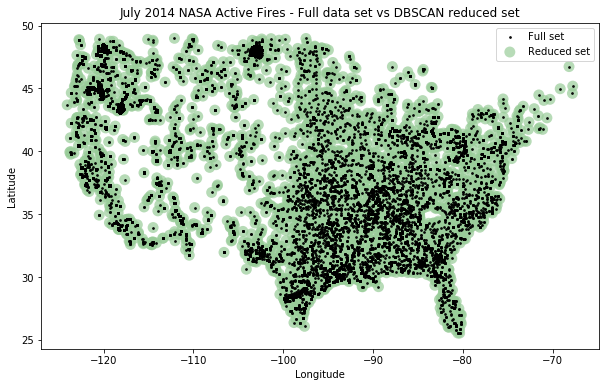

In [90]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(FRPdf2014['longitude'], FRPdf2014['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('July 2014 NASA Active Fires - Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

## MTBS Fires - Plotting for July 2014

In [98]:
MTBSbound = pd.read_csv('/Users/nahidmacbook/Documents/DataScience/Data-Wildfire/MTBS_Burned_Area_Boundary.csv')
MTBSbound2014 = MTBSbound[(MTBSbound.YEAR == 2014) & (MTBSbound.STARTMONTH == 7)]
MTBSbound2014.FIRE_ID.nunique()

110

In [99]:
MTBSfire = pd.read_csv('/Users/nahidmacbook/Documents/DataScience/Data-Wildfire/MTBS_Fire_Occurrence_Locations.csv')
MTBSfire.head()


,X,Y,OBJECTID,FIRE_ID,ASMNT_TYPE,PRE_ID,POST_ID,NODATA_THRESHOLD,LOW_THRESHOLD,MODERATE_THRESHOLD,HIGH_THRESHOLD,LATITUDE,LONGITUDE,FIRE_TYPE,FIRE_NAME,GREENNESS_THRESHOLD,IG_DATE,ACRES
0,-81.280003,25.952005,1001,FL2595208128019860107,Initial (SS),NaN,50160421986000,-9999,460,-9999,-9999,25.952,-81.280,Prescribed Fire,BASSLK TRR,-9999,1986-01-07T00:00:00.000Z,2750
1,-97.235007,30.130005,1002,TX3015109722520110904,Extended,50270392010235,70270392012200,-970,70,293,550,30.130,-97.235,Wildfire,BASTROP COUNTY COMPLEX,-150,2011-09-04T00:00:00.000Z,31838
2,-107.527011,43.639007,1003,WY4363910752719960825,Initial,50360301995241,50360301996200,-970,110,286,510,43.639,-107.527,Wildfire,BATES,-150,1996-08-25T00:00:00.000Z,47060
3,-102.297009,31.818005,1004,TX3178810230220110403,Initial (SS),NaN,50300382011100,-9999,-60,-335,-9999,31.818,-102.297,Wildfire,BATES FIELD FIRE,-9999,2011-04-03T00:00:00.000Z,3186
4,-104.973009,33.180005,1005,NM3322210500120110807,Initial (SS),NaN,50320372011300,-9999,-70,-200,-9999,33.180,-104.973,Wildfire,BATON ROUGE COMPLEX,-9999,2011-08-07T00:00:00.000Z,21641


In [100]:
### Create new dataframe, to then append data you want. 
MTBS2014 = pd.merge(MTBSbound2014, 
                   MTBSfire[['FIRE_ID','FIRE_NAME', 'LATITUDE', 'LONGITUDE', 'FIRE_TYPE']],
                     on ='FIRE_ID', 
                    how ='inner')
MTBS2014.FIRE_ID.nunique()

110

<function matplotlib.pyplot.show(*args, **kw)>

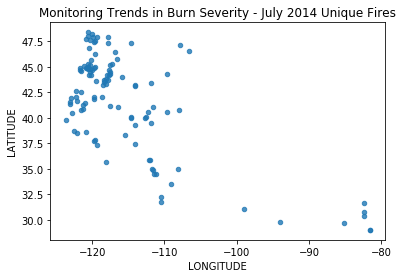

In [101]:
# Unique Fires in July of 2014

import matplotlib.pyplot as plt
MTBS2014.plot(kind="scatter", x="LONGITUDE", y="LATITUDE",alpha=0.8)
plt.title('Monitoring Trends in Burn Severity - July 2014 Unique Fires')
plt.show

## Emission - Plotting for July 2014

In [136]:
# load emission data into csv and check the shape of the dataset
Emission = pd.read_csv('/Users/nahidmacbook/Documents/DataScience/Data-Wildfire/emissions_year2003to2015.csv')
Emission.shape

(7254534, 22)

In [137]:
# check the number of unique fire ids
Emission.id.nunique()

2048759

In [102]:
# create a new dataset on July of 2014, limit the long/lat to the US.
Emission = pd.read_csv('/Users/nahidmacbook/Documents/DataScience/Data-Wildfire/emissions_year2003to2015.csv')
Emission2014 = Emission[(Emission.year == 2014) & (Emission.latitude > 45) & (Emission.longitude < -120) & (Emission.doy > 181) & (Emission.doy < 213)]
Emission2014.head()

,id,year,doy,longitude,latitude,grid10k,covertype,fuelcode,area_burned,prefire_fuel,...,ECO,ECH4,EPM2.5,cwd_frac,duff_frac,fuel_moisture_class,burn_source,burnday_source,BSEV,BSEV_flag
6270930,380713,2014,198,-121.9847,48.7158,131429,3,1260,62500.0,6989.973251,...,629.822967,35.421623,107.969652,0.321165,0.245802,2,2,12,3,1
6270931,380714,2014,198,-121.9815,48.7164,131429,3,1260,62500.0,6989.973251,...,552.142166,31.052808,94.652943,0.366350,0.280383,2,2,12,2,1
6270932,382357,2014,198,-121.9838,48.7136,131429,0,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2,2,12,0,1
6270933,382358,2014,195,-121.9806,48.7142,131429,3,1260,0.0,6989.973251,...,531.699850,29.903119,91.148546,0.380435,0.291163,2,2,12,1,1
6270934,382359,2014,195,-121.9773,48.7148,131429,3,1260,62500.0,6989.973251,...,629.822967,35.421623,107.969652,0.321165,0.245802,2,2,12,3,1


In [105]:
### Display results from honing in on grid area:
Emission2014[['latitude', 'longitude', 'ECO']]

,latitude,longitude,ECO
6270930,48.7158,-121.9847,629.822967
6270931,48.7164,-121.9815,552.142166
6270932,48.7136,-121.9838,0.000000
6270933,48.7142,-121.9806,531.699850
6270934,48.7148,-121.9773,629.822967
...,...,...,...
6330802,45.0021,-120.4976,445.540735
6330803,45.0027,-120.4945,553.351302
6330918,45.0005,-120.4937,445.540735
6330919,45.0011,-120.4906,445.540735


<function matplotlib.pyplot.show(*args, **kw)>

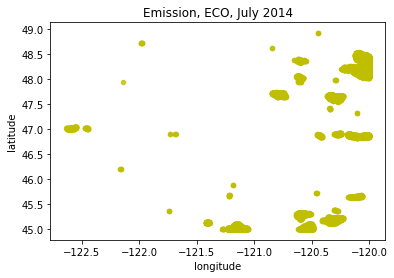

In [107]:
import matplotlib.pyplot as plt
Emission2014.plot(kind="scatter", x="longitude", y="latitude",alpha=0.8, color="y")
plt.title('Emission, ECO, July 2014')
plt.show